Exercise 6.10: Stochastic Wind (programming) Re-solve the windy gridworld task with
King’s moves, assuming that the e↵ect of the wind, if there is any, is stochastic, sometimes
varying by 1 from the mean values given for each column. That is, a third of the time
you move exactly according to these values, as in the previous exercise, but also a third
of the time you move one cell above that, and another third of the time you move one
cell below that. For example, if you are one cell to the right of the goal and you move
left, then one-third of the time you move one cell above the goal, one-third of the time
you move two cells above the goal, and one-third of the time you move to the goal.

In [31]:
import numpy as np
import matplotlib.pyplot as plt

ROWS = 7
COLS = 10
T_STATE = (3, 7)
WIND_STRENGTH = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 2,
    7: 2,
    8: 1,
    9: 0
}

def get_next_state_and_reward(state, action):
    row, col = state
    if action == "left":
        new_pos = (row, col - 1)
    elif action == "right":
        new_pos = (row, col + 1)
    elif action == "up":
        new_pos = (row - 1, col)
    elif action == "down":
        new_pos = (row + 1, col)
    elif action == "up_left":
        new_pos = (row - 1, col - 1)
    elif action == "up_right":
        new_pos = (row - 1, col + 1)
    elif action == "down_left":
        new_pos = (row + 1, col - 1)
    elif action == "down_right":
        new_pos = (row + 1, col + 1)
    elif action == "stay":
        new_pos = (row, col)
    
    # Apply stochastic wind effect
    random_wind = np.random.random()
    if random_wind < 1/3:
        # Normal wind effect
        wind_row = new_pos[0] - WIND_STRENGTH[new_pos[1]]
    elif random_wind < 2/3:
        # Wind effect + 1 (less wind)
        wind_row = new_pos[0] - WIND_STRENGTH[new_pos[1]] + 1
    else:
        # Wind effect - 1 (more wind)
        wind_row = new_pos[0] - WIND_STRENGTH[new_pos[1]] - 1
    
    # Apply boundary constraints to keep agent within grid
    final_row = max(0, min(ROWS - 1, wind_row))
    final_col = max(0, min(COLS - 1, new_pos[1]))
    new_pos = (final_row, final_col)

    if new_pos == T_STATE:
        reward = 0
    else:
        reward = -1

    return new_pos, reward

def get_next_action(state, action_values, epsilon=0.1):
    available_actions = []
    if state[0] > 0:
        available_actions.append("up")
    if state[0] < ROWS - 1:
        available_actions.append("down")
    if state[1] > 0:
        available_actions.append("left")
    if state[1] < COLS - 1:
        available_actions.append("right")
    if state[0] > 0 and state[1] > 0:
        available_actions.append("up_left")
    if state[0] > 0 and state[1] < COLS - 1:
        available_actions.append("up_right")
    if state[0] < ROWS - 1 and state[1] > 0:
        available_actions.append("down_left")
    if state[0] < ROWS - 1 and state[1] < COLS - 1:
        available_actions.append("down_right")
    available_actions.append("stay")

    if np.random.random() < epsilon:
        return np.random.choice(available_actions)
    else:
        return max(available_actions, key=lambda action: action_values[state[0]][state[1]][action])

INITIAL_STATE_ACTION_VALUES = [[{
    "left": 0,
    "right": 0,
    "up": 0,
    "down": 0,
    "up_left": 0,
    "up_right": 0,
    "down_left": 0,
    "down_right": 0,
    "stay": 0
} for _ in range(10)] for _ in range(7)]

In [32]:
import copy

def train_sarsa(
    initial_state_action_values,
    alpha=0.5,
    epsilon=0.1,
    episodes=200,
    decay_steps=None
):
    state_action_values = copy.deepcopy(initial_state_action_values)
    step_episodes = []
    for i in range(episodes):
        state = (3, 0)
        action = get_next_action(state, state_action_values, get_epsilon(i, initial_eps=epsilon, final_eps=0.001, decay_steps=150) if decay_steps else epsilon)
        while state != T_STATE:
            step_episodes.append(i)
            next_state, reward = get_next_state_and_reward(state, action)
            next_action = get_next_action(next_state, state_action_values, get_epsilon(i, initial_eps=epsilon, final_eps=0.001, decay_steps=150) if decay_steps else epsilon)
            state_action_values[state[0]][state[1]][action] += alpha * (reward + state_action_values[next_state[0]][next_state[1]][next_action] - state_action_values[state[0]][state[1]][action])
            state = next_state
            action = next_action

    return state_action_values, step_episodes

def get_epsilon(episode, initial_eps=.1, final_eps=0.001, decay_steps=150):
    if episode >= decay_steps:
        return final_eps
    return initial_eps - (initial_eps - final_eps) * (episode / decay_steps)

def generate_episode(state_action_values, epsilon=0.1):
    state = (3, 0)
    episode = [state]
    while state != T_STATE:
        action = get_next_action(state, state_action_values, epsilon)
        state, reward = get_next_state_and_reward(state, action)
        episode.append(state)
    
    return episode

def plot_episode(state_action_values, epsilon=0.1):
    episode_path = generate_episode(state_action_values, epsilon)
    print(len(episode_path))

    cols = [pos[1] for pos in episode_path]
    rows = [pos[0] for pos in episode_path]

    # Simple plot with dots
    plt.figure(figsize=(12, 8))
    plt.plot(cols, rows, 'o-', markersize=8, linewidth=2, label='Episode path')
    
    # Mark start and goal states
    plt.plot(0, 3, 's', markersize=12, color='green', label='Start (3,0)')
    plt.plot(7, 3, '*', markersize=15, color='red', label='Goal (3,7)')
    
    plt.xlim(-0.5, COLS - 0.5)  # 0 to 9 for columns
    plt.ylim(-0.5, ROWS - 0.5)  # 0 to 6 for rows
    
    # Add grid and formatting
    plt.grid(True, alpha=0.3)
    plt.gca().invert_yaxis()  # Flip y-axis so row 0 is at top
    
    # Add axis labels and title
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    
    # Set integer ticks for better grid visualization
    plt.xticks(range(COLS))
    plt.yticks(range(ROWS))
    
    plt.tight_layout()
    plt.show()

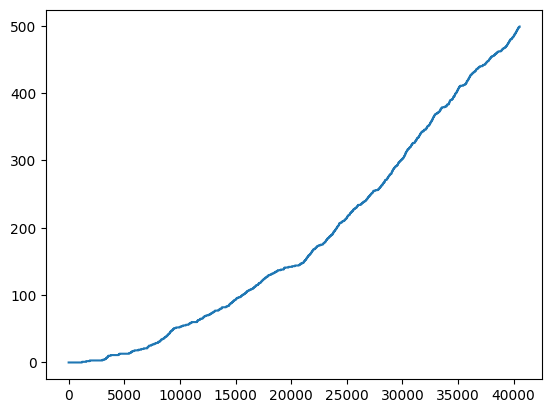

In [33]:
state_action_values, step_episodes = train_sarsa(
    INITIAL_STATE_ACTION_VALUES,
    alpha=0.5,
    epsilon=0.1,
    episodes=500
)

plt.plot(step_episodes)
plt.show()

47


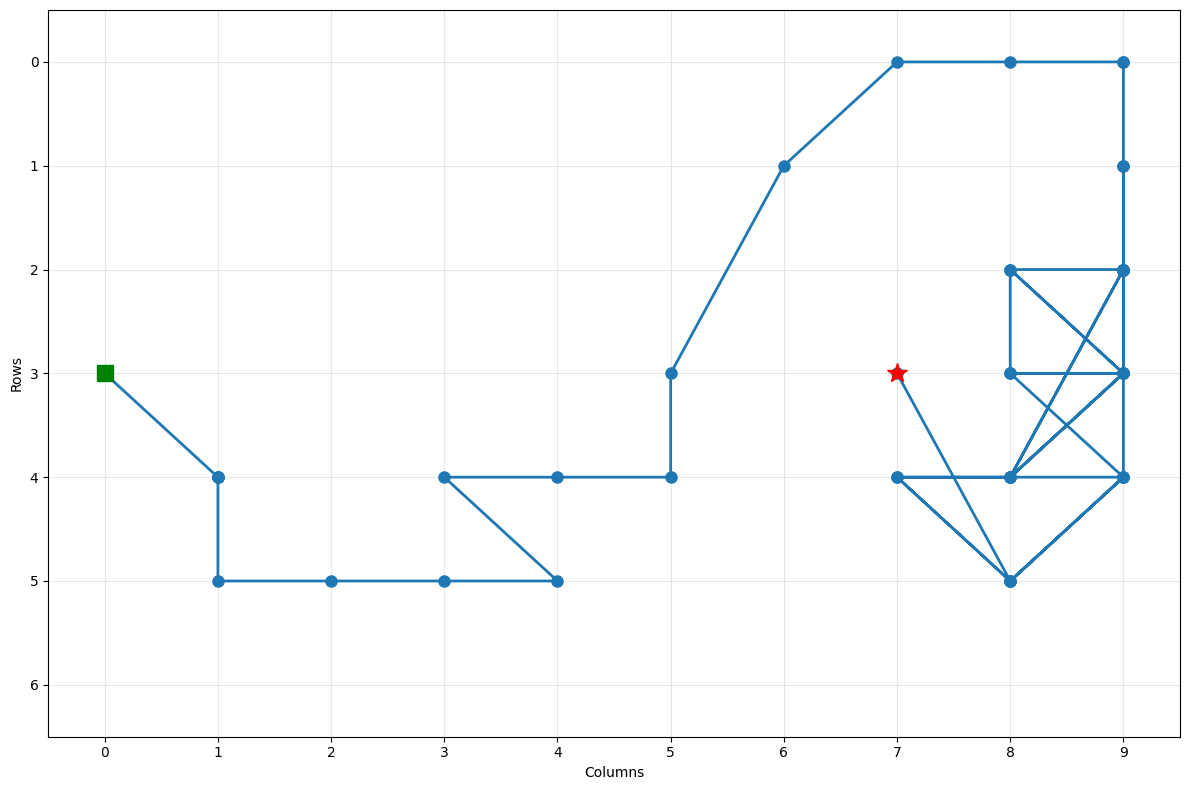

33


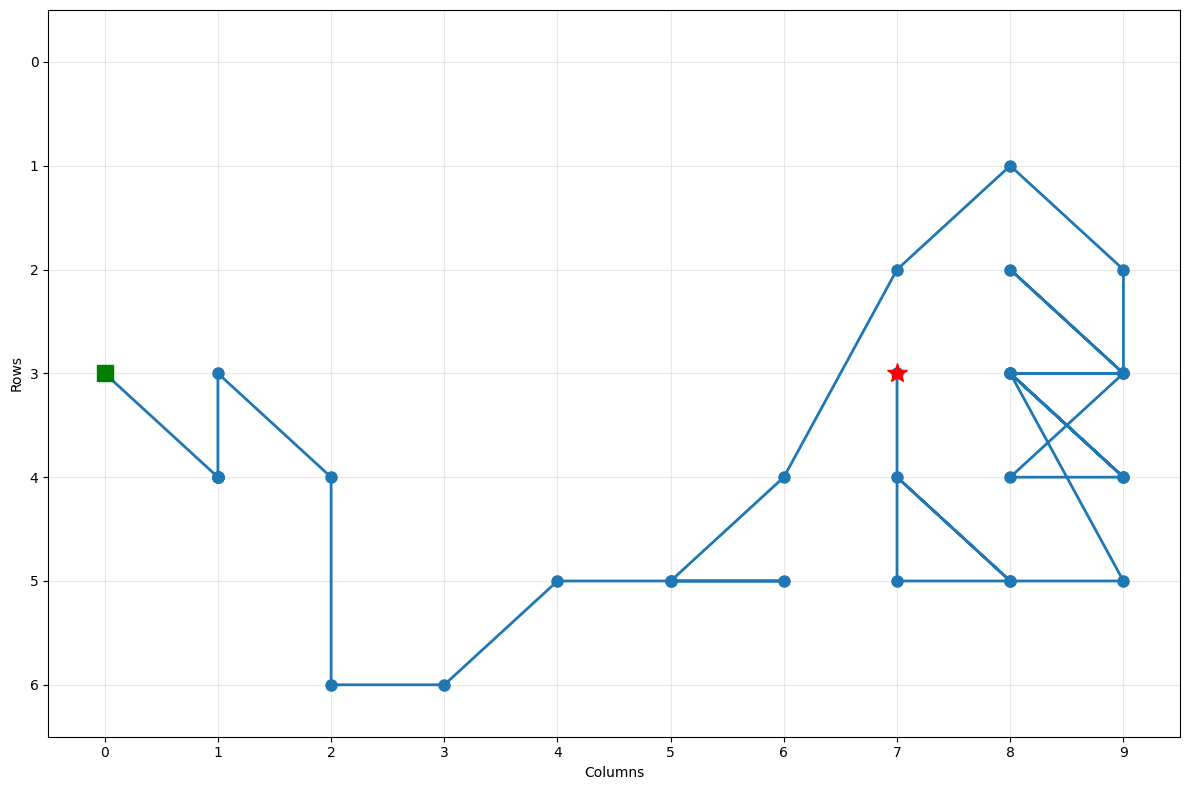

In [34]:
plot_episode(state_action_values, epsilon=0.1)
plot_episode(state_action_values, epsilon=0.00001)

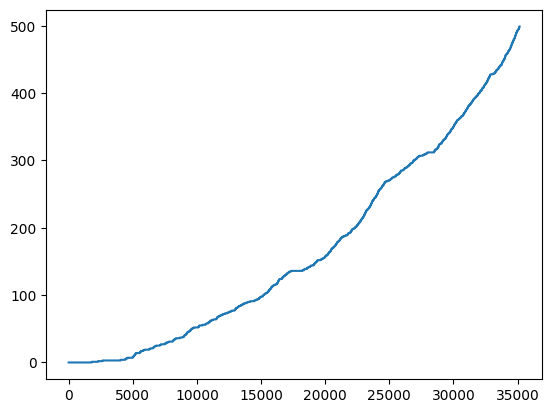

In [35]:
state_action_values, step_episodes = train_sarsa(
    INITIAL_STATE_ACTION_VALUES,
    alpha=0.5,
    epsilon=0.1,
    episodes=500,
    decay_steps=150
)

plt.plot(step_episodes)
plt.show()

24


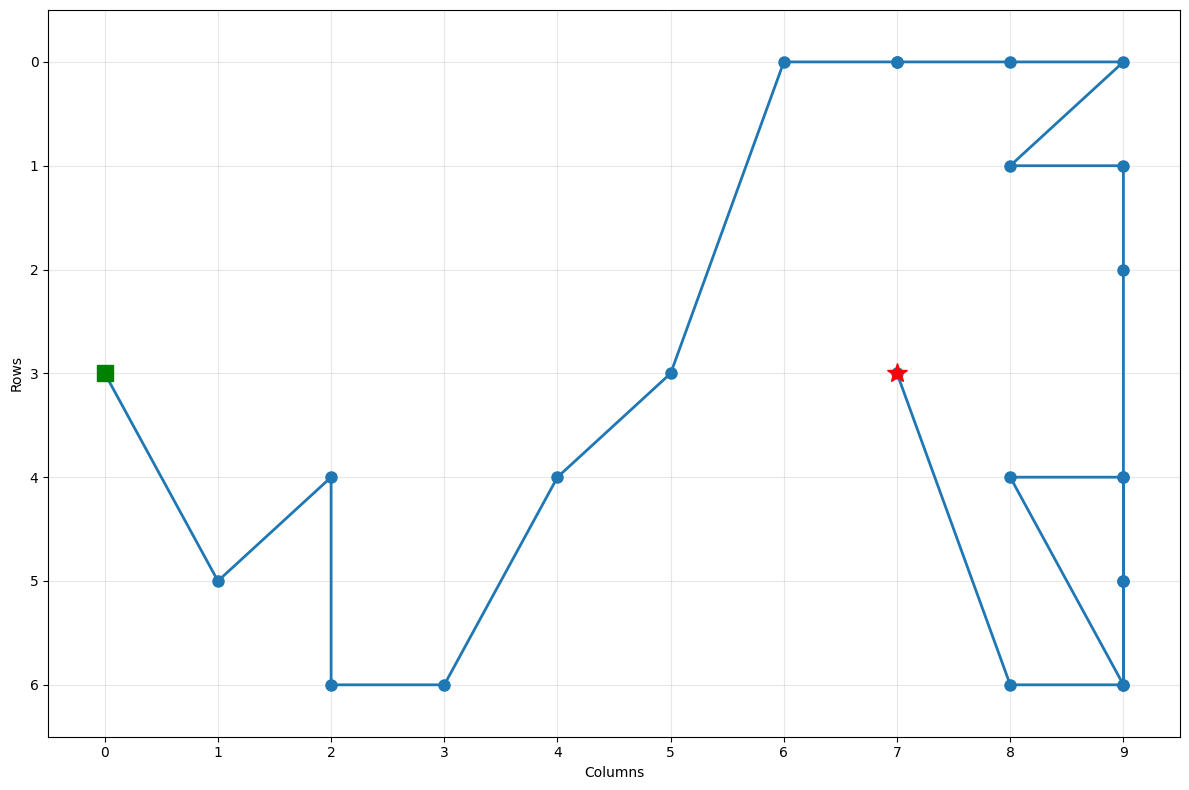

8


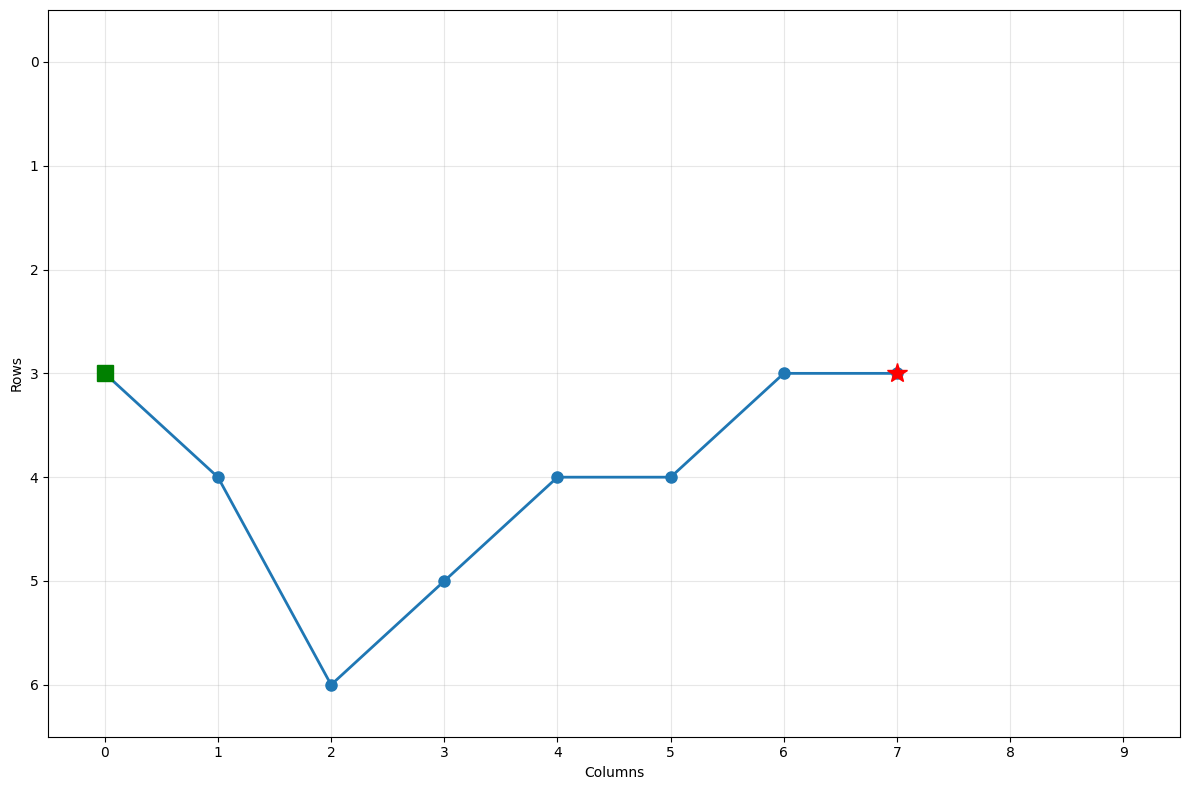

In [36]:
plot_episode(state_action_values, epsilon=0.1)
plot_episode(state_action_values, epsilon=0.00001)